# Self Organising Map

## The Kohonen Network

The instructions were not mine so i deleted them

In [1]:
#alrightimport numpy as np
import matplotlib.pyplot as plt

'''
input_data = np.random.random((10,3))
print(input_data)
plt.imshow([input_data])
'''

'\ninput_data = np.random.random((10,3))\nprint(input_data)\nplt.imshow([input_data])\n'

### 1. Implement a Kohonen network
- initialize with random values

In [2]:
#-- ADDITIONAL IMPORTS --

#this is too much information for me at the moment
#import cProfile, pstats, sys        #for timing and profiling: https://docs.python.org/2/library/profile.html#profile.Profile
import datetime                      #easier for now

from numba import cuda, float32      #for cuda
import math                          #for maths

In [3]:
#-- INIT DEFs --

#wrapping data generation in a funciton
def generate_input(num_colors, input_dim = 3):
    input_data = np.random.random((num_colors, input_dim))
    return input_data.astype(np.float32)#this is important for cuda

#wrapping np.random.random probably not needed
#I will use the same continuous uniform distribution that the input data was initialized with
def init_network(map_height, map_width, input_dimensions = 3):
    network = np.random.random((map_height, map_width, input_dimensions))
    return network.astype(np.float32)#this is important for cuda

In [4]:
#-- NUMPY DEFs --
#these are python/numpy only versions of the cuda defs below

#calculates the euclidean distance of a map of weights from a single color
def color_distance_np(weights, color):
    map_height = weights.shape[0]
    map_width = weights.shape[1]
    distances = np.ones(shape = (map_height,map_width), dtype = np.float32)
    distances = distances.astype(np.float32) 
    
    for y, row in enumerate(weights):
        for x, element in enumerate(row):
            sqrd_diff_r = (color[0] - element[0]) * (color[0] - element[0])
            sqrd_diff_g = (color[1] - element[1]) * (color[1] - element[1])
            sqrd_diff_b = (color[2] - element[2]) * (color[2] - element[2])
            
            sum_sqrd = sqrd_diff_r + sqrd_diff_g + sqrd_diff_b
            distances[y,x] = math.pow(sum_sqrd, 0.5) 
            
    return distances

#using numpy to find best matching unit
#I'm guessing that this is a pretty fast implementation
#perhaps it uses a reduction methods, which is the reason it flattens the array
def bmu_np(distances):
    map_width = distances.shape[1]
    flat_index = np.argmin(distances)
    y = flat_index // map_width  #floor
    x = flat_index % map_width   #modulo
    return y, x

#find neighbors, calculate influence and update weights
def update_weights_np(weights, bmu_y, bmu_x, radius_t, learn_rate_t, current_color):
    map_height = weights.shape[0]
    map_width = weights.shape[1]
    y_min = int(max(0, bmu_y - radius_t))
    y_max = int(min(map_height - 1, bmu_y + radius_t))
    x_min = int(max(0, bmu_x - radius_t))
    x_max = int(min(map_width - 1, bmu_x + radius_t))

    twosigmasqrd = 2 * radius_t * radius_t
    
    #copy bmu_vec
    bmu_vec = np.zeros(shape = [3], dtype = np.float32)
    bmu_vec = np.copy(weights[bmu_y][bmu_x])
    bmu_vec = bmu_vec.astype(np.float32)
    
    #let's go ahead and restrict our loops to the neighbourhood
    for y in range(y_min, y_max + 1):
        for x in range(x_min, x_max + 1):
            #as above
            #distance calce
            sqrd_diff_r = (weights[y][x][0] - bmu_vec[0]) * (weights[y][x][0] - bmu_vec[0])
            sqrd_diff_g = (weights[y][x][1] - bmu_vec[1]) * (weights[y][x][1] - bmu_vec[1])
            sqrd_diff_b = (weights[y][x][2] - bmu_vec[2]) * (weights[y][x][2] - bmu_vec[2])
            
            sum_sqrd = sqrd_diff_r + sqrd_diff_g + sqrd_diff_b
            distance = math.pow(sum_sqrd, 0.5) 
            
            #calc influence
            #decided to pass in copies of 2*sigma_t^2
            influence = math.exp(- (distance * distance) / twosigmasqrd)
            
            #update weights
            weights[y][x][0] = weights[y][x][0] + learn_rate_t * influence * (current_color[0] - weights[y][x][0])
            weights[y][x][1] = weights[y][x][1] + learn_rate_t * influence * (current_color[1] - weights[y][x][1])
            weights[y][x][2] = weights[y][x][2] + learn_rate_t * influence * (current_color[2] - weights[y][x][2])
    
    return weights


In [5]:
#-- NUMBA CUDA --

#i usually default to 1,64 or 8,8 or 4,4,4 because multiples of 64 should fit well on both nvidia and amd 
#however, perhaps we should only worry about nvidia since this is cuda, but 64 should occupy 32 threads per streaming multiprocessor well
THREADS_PER_BLOCK_2D = (8,8)

#I'm making the assumption that this will always deal with color vectors of len 3
#called from color_distance_cuda
@cuda.jit
def distance_kernel(weights, color, distances, map_height, map_width):
    y, x = cuda.grid(2)    #row major, so y first
    
    #number of threads don't usually match size of data
    if y < map_height and x < map_width:

        sqrd_diff_r = (color[0] - weights[y][x][0]) * (color[0] - weights[y][x][0])
        sqrd_diff_g = (color[1] - weights[y][x][1]) * (color[1] - weights[y][x][1])
        sqrd_diff_b = (color[2] - weights[y][x][2]) * (color[2] - weights[y][x][2])
        
        sum_sqrd = sqrd_diff_r + sqrd_diff_g + sqrd_diff_b
        distances[y,x] = math.pow(sum_sqrd, 0.5)              #because there is no math.sqrt on GPU
        
'''
@cuda.jit
def bmu_cuda(distances, result):
    #I need to figure this out from here probably:  https://cuvilib.com/Reduction.pdf
    #but for now just use numpy
    '''

#this function wraps the cuda call
#this is because we need to allocate new shared memory for cuda to read and write to
#also, there is a lot of fussiness over typeing because kernels need explicit types for jit compilation and this isn't natural to python
def color_distance_cuda(weights, color):
    map_height = weights.shape[0]
    map_width = weights.shape[1]
    distances_cuda = np.ones(shape = (map_height,map_width), dtype = np.float32)
    distances_cuda = distances_cuda.astype(np.float32) 
            
    blocks_per_grid_y = math.ceil(map_height / THREADS_PER_BLOCK_2D[0])
    blocks_per_grid_x = math.ceil(map_width / THREADS_PER_BLOCK_2D[1])
    blocks_per_grid = (blocks_per_grid_y, blocks_per_grid_x)
    
    distance_kernel[blocks_per_grid, THREADS_PER_BLOCK_2D](weights, color, distances_cuda, map_height, map_width)
    return distances_cuda

#we'll check the neighborhood inside this kernel
#this is the actual kernel.  It is called from update_weights_cuda
@cuda.jit 
def update_weights_kernel(weights, bmu_vec, y_min, y_max, x_min, x_max, twosigmasqrd, learn_rate_t, current_color):
    y, x = cuda.grid(2)    #row major, so y first

        
    #4.2) NEIGHBOURHOOD
    #maybe too much if statements?  perhaps could use a mask instead
    #if y >= y_min and y <= (y_max + 1) and x >= x_min and x <= (x_max + 1):
    if y >= y_min and y <= (y_max) and x >= x_min and x <= (x_max):
        #as above
        #distance calce
        sqrd_diff_r = (weights[y][x][0] - bmu_vec[0]) * (weights[y][x][0] - bmu_vec[0])
        sqrd_diff_g = (weights[y][x][1] - bmu_vec[1]) * (weights[y][x][1] - bmu_vec[1])
        sqrd_diff_b = (weights[y][x][2] - bmu_vec[2]) * (weights[y][x][2] - bmu_vec[2])
            
        sum_sqrd = sqrd_diff_r + sqrd_diff_g + sqrd_diff_b
        distance = math.pow(sum_sqrd, 0.5) 
            
        #5.)
            
        #calc influence
        #decided to pass in copies of 2*sigma_t^2
        influence = math.exp(- (distance * distance) / twosigmasqrd)
            
        #update weights
        weights[y][x][0] = weights[y][x][0] + learn_rate_t * influence * (current_color[0] - weights[y][x][0])
        weights[y][x][1] = weights[y][x][1] + learn_rate_t * influence * (current_color[1] - weights[y][x][1])
        weights[y][x][2] = weights[y][x][2] + learn_rate_t * influence * (current_color[2] - weights[y][x][2])
        
#find neighbors, calculate influence and update weights
#calls the kernel:  performs a few global calcs and allocates new memory
def update_weights_cuda(weights, bmu_y, bmu_x, radius_t, learn_rate_t, current_color):
    map_height = weights.shape[0]
    map_width = weights.shape[1]
    
    y_min = max(0, bmu_y - radius_t)
    y_max = min(map_height - 1, bmu_y + radius_t)
    x_min = max(0, bmu_x - radius_t)
    x_max = min(map_width - 1, bmu_x + radius_t)
    
    twosigmasqrd = 2 * radius_t * radius_t
    
    #copying and specifiying types
    these_weights = np.zeros(shape = weights.shape, dtype = np.float32)
    these_weights = np.copy(weights)
    these_weights = these_weights.astype(np.float32)#this is now likely excessive, but just making sure
    
    #copy bmu_vec
    bmu_vec = np.zeros(shape = [3], dtype = np.float32)
    bmu_vec = np.copy(weights[bmu_y][bmu_x])
    bmu_vec = bmu_vec.astype(np.float32)
    
    blocks_per_grid_y = math.ceil(map_height / THREADS_PER_BLOCK_2D[0])
    blocks_per_grid_x = math.ceil(map_width / THREADS_PER_BLOCK_2D[1])
    blocks_per_grid = (blocks_per_grid_y, blocks_per_grid_x)
    
    update_weights_kernel[blocks_per_grid, THREADS_PER_BLOCK_2D](these_weights, bmu_vec, y_min, y_max, x_min, x_max, twosigmasqrd, learn_rate_t, current_color)
    
    return these_weights

In [6]:
#-- TRAINING DEFS --
#train for a given number of iterations
#it's the same for both cuda and pure numpy implementations

def train_cuda(weights, input_data, num_iterations, map_width):
    weights_new = np.zeros(shape = weights.shape, dtype = np.float32)
    weights_new = np.copy(weights)
    weights_new = weights_new.astype(np.float32)#this is now likely excessive, but just making sure    
    
    i = 0
    #iterate
    while i < num_iterations:
        
        #4.1) calculate the radius
        #since radius calc depends on iteration (not sample), calc outside of sample loop 
        radius_t = RADIUS_0 * math.exp( - i / TIME_CONST_LAMBDA)
        
        #calculate the learning rate
        learn_rate_t = LEARN_RATE_0 * math.exp( - i / TIME_CONST_LAMBDA)
        
        
        curr_index = np.random.randint(0, len(input_data))
        
        current_color = input_data[curr_index]
        
        # 3.) FIND THE BEST MATCHING UNIT
        distances = color_distance_cuda(weights, current_color)
        bmu_y, bmu_x = bmu_np(distances)
            #print(distances[bmu_y, bmu_x])
           
        #5.) update weights
        weights_new = update_weights_cuda(weights_new, bmu_y, bmu_x, radius_t, learn_rate_t, current_color)            
            
        i += 1
    return weights_new
        
def train_np(weights, input_data, num_iterations, map_width):
    weights_new = np.zeros(shape = weights.shape, dtype = np.float32)
    weights_new = np.copy(weights)
    weights_new = weights_new.astype(np.float32)#this is now likely excessive, but just making sure  
    
    i = 0
    #iterate
    while i < num_iterations:
        
        #4.1) calculate the radius
        #since radius calc depends on iteration (not sample), calc outside of sample loop 
        radius_t = RADIUS_0 * math.exp( - i / TIME_CONST_LAMBDA)
        
        #calculate the learning rate
        learn_rate_t = LEARN_RATE_0 * math.exp( - i / TIME_CONST_LAMBDA)
        
        curr_index = np.random.randint(0, len(input_data))
        
        current_color = input_data[curr_index]
        
        # 3.) FIND THE BEST MATCHING UNIT
        distances = color_distance_cuda(weights, current_color)
        bmu_y, bmu_x = bmu_np(distances)
            
        #5.) update weights
        weights_new = update_weights_np(weights_new, bmu_y, bmu_x, radius_t, learn_rate_t, current_color)            
        i += 1
        
    return weights_new

### 2. Train a 10x10 network over 100 iterations

- Training data is a random set of 20 colours

In [7]:
#-- HYPERPARAMETERS --
MAP_HEIGHT        = 10
MAP_WIDTH         = 10
NUM_COLORS        = 20
NUM_ITERATIONS    = 100
LEARN_RATE_0      = 0.1

#-- CALC'D STATIC --
RADIUS_0          = (max(MAP_HEIGHT, MAP_WIDTH)) / 2
TIME_CONST_LAMBDA = NUM_ITERATIONS / math.log(RADIUS_0)

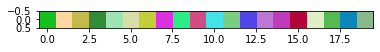

In [8]:
#-- 1.) INITIALIZE DATA AND NETWORK -- 

input_data = generate_input(NUM_COLORS)
kohonen = init_network(MAP_HEIGHT, MAP_WIDTH)

#sanity check input data
plt.imshow([input_data])

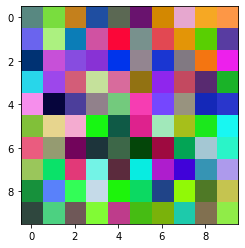

In [9]:
#sanity check network
plt.imshow(kohonen)

In [ ]:
#-- 2.) 6.)  LET'S TRAIN CUDA portion--

#copy for cuda loop
weights_cuda = np.zeros(shape = kohonen.shape, dtype = np.float32)
weights_cuda = np.copy(kohonen)
weights_cuda = weights_cuda.astype(np.float32)#this is now likely excessive, but just making sure

#got help from here: https://stackoverflow.com/questions/1584425/return-value-while-using-cprofile
profiler = cProfile.Profile()
profiler.enable()

weights = profiler.runcall(train_cuda, weights, input_data, NUM_ITERATIONS, MAP_WIDTH)
profiler.disable()
profiler_stats = pstats.Stats(profiler, stream = sys.stdout)
profiler_stats.print_stats()

#time and perform the training
start_time = datetime.datetime.now()
weights_cuda_fin = train_cuda(weights_cuda, input_data, NUM_ITERATIONS, MAP_WIDTH)
end_time = datetime.datetime.now()
print("CUDA accelerated training time and result below (%i iterations)" % (NUM_ITERATIONS))
print("CUDA compilation overhead is an enourmous portion of the time taken")
print(end_time - start_time)
plt.imshow(weights_cuda_fin)
'''
print(weights_cuda_fin.shape)
print(kohonen.shape)
difference = np.subtract(kohonen, weights_cuda)
print(difference)
'''


CUDA accelerated training and result below (200 iterations)
0:00:00.704571


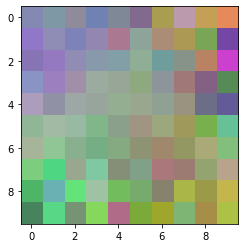

In [11]:
#200 iterations with cuda
NUM_ITERATIONS = 200

#copy for cuda loop
weights_cuda_200 = np.zeros(shape = kohonen.shape, dtype = np.float32)
weights_cuda_200 = np.copy(kohonen)
weights_cuda_200 = weights_cuda_200.astype(np.float32)#this is now likely excessive, but just making sure

#time and perform the training
start_time = datetime.datetime.now()
weights_cuda_fin_200 = train_cuda(weights_cuda_200, input_data, NUM_ITERATIONS, MAP_WIDTH)
end_time = datetime.datetime.now()
print("CUDA accelerated training and result below (%i iterations)" % (NUM_ITERATIONS))
print(end_time - start_time)
plt.imshow(weights_cuda_fin_200)

CUDA accelerated training and result below (500 iterations)
0:00:02.415805


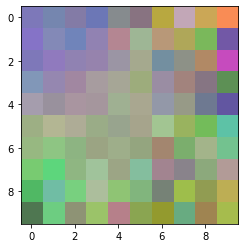

In [12]:
#500 iterations with cuda
NUM_ITERATIONS = 500

#copy for cuda loop
weights_cuda_500 = np.zeros(shape = kohonen.shape, dtype = np.float32)
weights_cuda_500 = np.copy(kohonen)
weights_cuda_500 = weights_cuda_500.astype(np.float32)#this is now likely excessive, but just making sure

#time and perform the training
start_time = datetime.datetime.now()
weights_cuda_fin_500 = train_cuda(weights_cuda_500, input_data, NUM_ITERATIONS, MAP_WIDTH)
end_time = datetime.datetime.now()
print("CUDA accelerated training and result below (%i iterations)" % (NUM_ITERATIONS))
print(end_time - start_time)
plt.imshow(weights_cuda_fin_500)

### 3. Train a 100x100 network over 1000 iterations

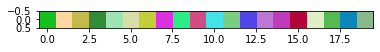

In [16]:
#-- HYPERPARAMETERS --
MAP_HEIGHT        = 100
MAP_WIDTH         = 100

NUM_ITERATIONS    = 1000
LEARN_RATE_0      = 0.1

#-- CALC'D STATIC --
RADIUS_0          = (max(MAP_HEIGHT, MAP_WIDTH)) / 2
TIME_CONST_LAMBDA = NUM_ITERATIONS / math.log(RADIUS_0)
#-- 1.) INITIALIZE DATA AND NETWORK -- 

kohonen2 = init_network(MAP_HEIGHT, MAP_WIDTH)

#sanity check input data
plt.imshow([input_data])

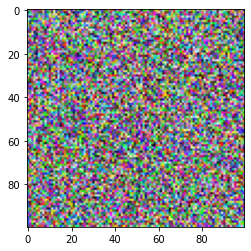

In [17]:
#sanity check network
plt.imshow(kohonen2)

CUDA accelerated training time and (1000 iterations)
0:00:03.848022


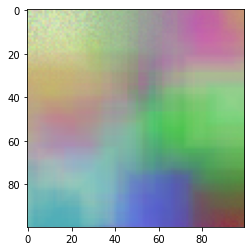

In [18]:
#-- 2.) 6.)  LET'S TRAIN CUDA portion--

#copy for cuda loop
weights_cuda2 = np.zeros(shape = kohonen2.shape, dtype = np.float32)
weights_cuda2 = np.copy(kohonen2)
weights_cuda2 = weights_cuda2.astype(np.float32)#this is now likely excessive, but just making sure

#time and perform the training
start_time = datetime.datetime.now()
weights_cuda_fin2 = train_cuda(weights_cuda2, input_data, NUM_ITERATIONS, MAP_WIDTH)
end_time = datetime.datetime.now()
print("CUDA accelerated training time and (%i iterations)" % (NUM_ITERATIONS))
print(end_time - start_time)
plt.imshow(weights_cuda_fin2)